In [8]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

# ipysh.Bootstrap_support.debug()

# TEST QSH


In [3]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError
    
qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])


print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [4]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    # Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0830 10:01:02.658834 140167645992768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=56, shape=(1, 24), dtype=float32, numpy=
 array([[0.27212694, 0.5461841 , 0.4617475 , 0.6197208 , 0.09811427,
         0.0283305 , 0.03905496, 0.02513968, 0.021162  , 0.01682363,
         0.02190124, 0.02255967, 0.00139233, 0.01161886, 0.29665753,
         0.47287965, 0.61732644, 0.16147815, 0.25720704, 0.22995938,
         0.29333192, 0.29539174, 0.96551704, 0.290219  ]], dtype=float32)>,
 <tf.Tensor: id=57, shape=(1, 30), dtype=float32, numpy=
 array([[0.05801162, 0.10545969, 0.1553483 , 0.20822442, 0.27422595,
         0.34855986, 0.42947042, 0.51404023, 0.59861016, 0.6795207 ,
         0.7538546 , 0.8198561 , 0.87442696, 0.9215261 , 0.96382195,
         0.1221641 , 0.17849371, 0.20343137, 0.20565361, 0.2058488 ,
         0.21717635, 0.2158439 , 0.20784654, 0.21624364, 0.2167361 ,
         0.19784038, 0.1844079 , 0.20149851, 0.19533376, 0.16678818]],
       dtype=float32)>)

In [5]:
gan = models.AEFIT5.AEFIT5(latent_dim=24, feature_dim=30, dprate=0., scale=1, geometry=[1,80,80,50])
gan.inference_net.trainable = False
l1 = tf.keras.regularizers.l1
l2 = tf.keras.regularizers.l2
for l in gan.generative_net.layers:
    if issubclass(type(l), tf.keras.layers.Dense):
        l.activity_regularizer = l1(0.01)
# gan.generative_net.compile( gan.optimizer, loss = tf.losses.mean_absolute_error )        
gan.generative_net.compile( tf.optimizers.Adam(1e-3), loss = gan.loss )


W0830 10:01:09.358592 140167645992768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


AEFIT5 a ready:


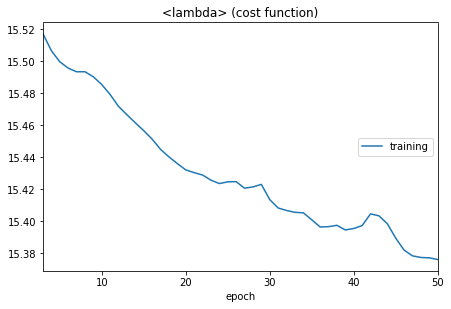

<lambda> (cost function):
training   (min:   15.376, max:   15.544, cur:   15.376)
80/80 [==============================] - 6s 69ms/step - loss: 15.3762


In [9]:
# models.base.train_thread(gan.generative_net, ds, epoch=30, batch=100, learning_rate=1e-3, callbacks=[]).control_panel()
import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass

gan.generative_net.fit( ds.batch(100).take(80), epochs=50, callbacks=[PlotLossesCallback()] )

In [10]:
print(qsh[0].n)
gan.generative_net.layers[0].weights

[ 7  8  9 10 11 12 13 14 15 16]


[<tf.Variable 'aefi_t5_gRlv/kernel:0' shape=(24,) dtype=float32, numpy=
 array([0.6919606 , 0.70104605, 0.68109196, 0.6797082 , 0.82463825,
        0.97050935, 0.8651875 , 0.8183297 , 0.7948377 , 0.9999999 ,
        0.8598238 , 0.9083993 , 0.9515539 , 0.98917806, 0.6438119 ,
        0.6841213 , 0.6054738 , 0.6377242 , 0.6163072 , 0.6798733 ,
        0.6182007 , 0.6588098 , 0.62829983, 0.65680176], dtype=float32)>]

In [114]:
# gan.save('step12_gan_PBr')
gan.load('step12_gan_PBr')

In [115]:
pos = 0

116


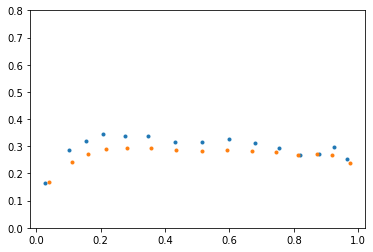

In [232]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy):
    plt.figure('plot')
    ax = plt.gca()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.')

xy = d_pos[1]
XY = gan.generative_net(d_pos[0], training=False)
XY = tf.sigmoid(XY)
plot(xy)
plot(XY)
pos += 1

In [ ]:
vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=44, dprate=0.5, scale=1, beta=0.)

In [ ]:
models.base.train_thread(vae, ds, batch=100, epoch=6, callbacks=[] ).control_panel()


In [ ]:
p = Hplt.LSPlotBokeh()
p.set_model(vae)
p.set_data(qsh, feed_data=ds, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

In [ ]:
# [ v.name for v in h2.trainable_variables ]
def plot(xy):
    plt.figure('data')
    ax = plt.gca()
    ax.set_ylim(0.,1.)
    x,y = tf.split(xy[0], num_or_size_splits=2)
    plt.plot(x,y,'.')
d = [x for x in ds.shuffle(1000).batch(1).take(100)][0]
d0 = d[0][0]
y0 = h(d[0], training=False)
y0 = tf.sigmoid(y0[0])
plot(d0)
plot(y0)



In [ ]:
# tbordo tcentro Ip NS VT F
xy,_ =  [x for x in ds.batch(1).take(1)][0]
par = xy[2]

l,_ = h.encode(xy, training=False)
XY  = h.decode(l, training=False, apply_sigmoid=True) 
PAR = XY[2]

print( list(zip(par, PAR)) )


In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)

# sx = []
# sy = []
# for xy in ds.batch(1).take(1000):
#     xy,_ = xy
#     x,y = tf.split(xy[0],2, axis=1)
#     me,_  = h.encode(xy, training=False)
#     gpt = me[0].numpy()
#     #ax1.scatter(gpt[0],gpt[1])
#     sx.append(gpt[0])
#     sy.append(gpt[1])

# ax1.scatter(sx,sy)
    
for xy in ds.shuffle(100).batch(1).take(1):    
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    ax2.scatter(x,y,s=80)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = h.decode(me, training=False)[0]
    XY = tf.sigmoid(XY)
    X,Y = tf.split(XY[0], num_or_size_splits=2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1

In [ ]:
xy,_ = [x for x in ds.batch(2).take(1)][0]
me,va = h.encode(xy)
XY = h.decode(me, apply_sigmoid=True)
XY[0][0]